# Detection of Swing and Stance Phase from a Shank-Worn IMU

**Author:** Robbin Romijnders  
**Last update:** 18 Feb 2022

## Prerequisites

In [1]:
from datasets import keepcontrol
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tcn import TCN, tcn_full_summary
from utils.models import get_base_model
from utils.losses import MyWeightedBinaryCrossentropy
from utils.hyperparam_tuning import tune
from utils.evaluate import compare_events
import keras_tuner as kt
from keras_tuner import HyperModel
from scipy.signal import find_peaks

In [2]:
# Global variables
PATH = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"
DEMOGRAPHICS_FILE = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/participants.tsv" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata\\participants.tsv"
TRACKED_POINTS = ["left_ankle", "right_ankle"]
CLASSIFICATION_TASK = "events"
WIN_LEN = 400
DERIVATIVES_PATH = os.path.join(os.path.split(PATH)[0], "derivatives", "motion", "doe")

# Tuner settings
MAX_TRIALS = 10
EXECUTIONS_PER_TRIAL = 2

# Search settings
EPOCHS = 30
CALLBACKS = [keras.callbacks.EarlyStopping(patience=5, monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(patience=5, monitor="val_loss", factor=0.1)]

## Get the data

In [3]:
ds_train, ds_val, ds_test = keepcontrol.load_data(
    path=PATH,
    filename=DEMOGRAPHICS_FILE,
    tracked_points=TRACKED_POINTS,
    incl_magn=False,
    classification_task=CLASSIFICATION_TASK,
    win_len=WIN_LEN
)

Load dataset from pickle ...


For the training and validation datasets, a tuple is returned that is composed as (`train_labels`, `train_labels`, `train_filenames`, `train_ids`).

- `train_data` is a numpy array with shape: (`batch_size`, `win_len`, `num_channels`)  
- `train_labels` is a numpy array with shape: (`batch_size`, `win_len`, `1`), where the last array dimensions codes 0 = stance phase, 1 = swing phase

In [4]:
# Split datasets in data and labels
(train_data, train_labels, train_filenames, train_ids) = ds_train
(val_data, val_labels, val_filenames, val_ids) = ds_val

In [5]:
# Shape: (batch_size, win_len, num_channels)
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of train labels: {train_labels.shape}")
print(f"Shape of val data: {val_data.shape}")
print(f"Shape of val labels: {val_labels.shape}")

Shape of train data: (3472, 400, 6)
Shape of train labels: (3472, 400, 2)
Shape of val data: (714, 400, 6)
Shape of val labels: (714, 400, 2)


In [6]:
# Organize labels in a dictionary -- splitting events (IC, FC)
train_targets, val_targets = {}, {}
for i in range(train_labels.shape[-1]):
    train_targets[f"outputs_{i+1}"] = np.expand_dims(train_labels[:,:,i], axis=-1)
    val_targets[f"outputs_{i+1}"] = np.expand_dims(val_labels[:,:,i], axis=-1)

In [7]:
# Hyperparameter tuning
tuner = tune(
    train_data=train_data,
    train_targets=train_targets,
    validation_data=(val_data, val_targets),
    tuner_settings={"max_trials": MAX_TRIALS,
                    "executions_per_trial": EXECUTIONS_PER_TRIAL},
    search_settings={"epochs": EPOCHS,
                     "callbacks": CALLBACKS}
)

Start hyperparameter tuning ...
INFO:tensorflow:Oracle triggered exit


In [8]:
# Get hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Found best model architecture")
print(f"    # filters: {2**best_hps.get('nb_filters'):d}")
print(f"    kernel size: {best_hps.get('kernel_size'):d}")
print(f"    padding: {best_hps.get('padding'):s}")
print(f"    dilations: {[2**i for i in range(best_hps.get('dilations'))]}")

Found best model architecture
    # filters: 16
    kernel size: 5
    padding: same
    dilations: [1, 2, 4]


In [10]:
# Build model
optim_model = tuner.hypermodel.build(best_hps)

In [11]:
# Concatenate training and validation data
train_val_data = np.concatenate((train_data, val_data), axis=0)
train_val_targets = {}
for k, v in train_targets.items():
    train_val_targets[k] = np.concatenate((train_targets[k], val_targets[k]), axis=0)

In [12]:
# Fit optimized model to combined training and validation data
history = optim_model.fit(
    x=train_val_data,
    y=train_val_targets,
    batch_size=64, 
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
    callbacks=CALLBACKS
)

Epoch 1/20
59/59 [==============================] - 4s 41ms/step - loss: 0.0220 - outputs_1_loss: 0.0109 - outputs_2_loss: 0.0111 - outputs_1_binary_accuracy: 0.9009 - outputs_2_binary_accuracy: 0.9102 - val_loss: 0.0069 - val_outputs_1_loss: 0.0032 - val_outputs_2_loss: 0.0037 - val_outputs_1_binary_accuracy: 0.9441 - val_outputs_2_binary_accuracy: 0.9419 - lr: 0.0010
Epoch 2/20
59/59 [==============================] - 1s 24ms/step - loss: 0.0050 - outputs_1_loss: 0.0026 - outputs_2_loss: 0.0024 - outputs_1_binary_accuracy: 0.9537 - outputs_2_binary_accuracy: 0.9520 - val_loss: 0.0068 - val_outputs_1_loss: 0.0029 - val_outputs_2_loss: 0.0038 - val_outputs_1_binary_accuracy: 0.9516 - val_outputs_2_binary_accuracy: 0.9590 - lr: 0.0010
Epoch 3/20
59/59 [==============================] - 1s 24ms/step - loss: 0.0040 - outputs_1_loss: 0.0021 - outputs_2_loss: 0.0019 - outputs_1_binary_accuracy: 0.9582 - outputs_2_binary_accuracy: 0.9591 - val_loss: 0.0069 - val_outputs_1_loss: 0.0031 - val_

## Evaluate using test dataset

In [13]:
from utils.data_utils import select_data, get_gait_events, get_labels
from utils.preprocessing import resamp1d

In [25]:
# Output variables
out_sub_ids = []
out_filenames = []
out_event_types = []
out_reference_timings = []
out_predicted_timings = []

# Get a list of test subject ids
test_ids = ds_test

skip_files = {18: [4]}

# Loop over the subject ids
for (i_sub_id, sub_id) in enumerate(test_ids[18:]):
    
    # Get a list of files that contain annotated gait events
    test_filenames = [fname for fname in os.listdir(os.path.join(PATH, sub_id, "motion")) if (fname.endswith("_events.tsv")) and ("_task-walk" in fname)]
    
    # Loop over these filename
    for (i_test_filename, test_filename) in enumerate(test_filenames[:]):
        print(f"{i_test_filename:d} {test_filename:s}")
        
        # Load the IMU motion and channels files
        df_imu = pd.read_csv(
            os.path.join(PATH, sub_id, "motion", test_filename.replace("_events.tsv", "_tracksys-imu_motion.tsv")), 
            sep="\t", 
            header=0
        )
        df_imu_channels = pd.read_csv(
            os.path.join(PATH, sub_id, "motion", test_filename.replace("_events.tsv", "_tracksys-imu_channels.tsv")), 
            sep="\t", 
            header=0
        )
        
        # Resample if necessary
        if df_imu_channels["sampling_frequency"].iloc[0] != 200:
            X = df_imu.to_numpy()
            X = resamp1d(X, df_imu_channels["sampling_frequency"].iloc[0], 200)
            df_imu = pd.DataFrame(data=X, columns=df_imu.columns)
            del X
        
        # Select data from given tracked points
        df_select = select_data(df_imu, df_imu_channels, tracked_points=TRACKED_POINTS, incl_magn=False)
        
        # Determine start and end of current task trial
        df_events = pd.read_csv(os.path.join(PATH, sub_id, "motion", test_filename), sep="\t", header=0)
        indx_start = df_events[df_events["event_type"]=="start"]["onset"].values[0] - 1
        indx_stop = df_events[df_events["event_type"]=="stop"]["onset"].values[0]
        df_events = df_events.loc[(df_events["onset"]>=indx_start) & (df_events["onset"]<=indx_stop)]
        df_select = df_select.iloc[indx_start:indx_stop]
        
        # Normalize
        normalize = True
        if normalize:
            df_select = ( df_select - df_select.mean() ) / df_select.std()
        
        # Get indices corresponding to gait events
        events = get_gait_events(df_events=df_events)
        
        # Get labels
        labels = get_labels(len(df_select), events, classification_task=CLASSIFICATION_TASK)
        
        # Convert data to numpy array
        data = df_select.to_numpy()
        
        # Split left/right
        data = np.stack([data[:,:data.shape[-1]//len(TRACKED_POINTS)], data[:,data.shape[-1]//len(TRACKED_POINTS):]], axis=0)
        labels = np.stack([labels[:,:labels.shape[-1]//len(TRACKED_POINTS)], labels[:,labels.shape[-1]//len(TRACKED_POINTS):]], axis=0)
        
        # Make predictions
        predictions = optim_model.predict(data)
        
        # Derive indices corresponding to gait events from predictions
        ix_pred_ICL, pk_props = find_peaks(predictions[0][0][:,0], height=0.5, distance=100)
        ix_pred_FCL, pk_props = find_peaks(predictions[1][0][:,0], height=0.5, distance=100)
        ix_pred_ICR, pk_props = find_peaks(predictions[0][1][:,0], height=0.5, distance=100)
        ix_pred_FCR, pk_props = find_peaks(predictions[1][1][:,0], height=0.5, distance=100)
        
        ix_true_ICL = np.argwhere(labels[0][:,0]==1)[:,0]
        ix_true_FCL = np.argwhere(labels[0][:,1]==1)[:,0]
        ix_true_ICR = np.argwhere(labels[1][:,0]==1)[:,0]
        ix_true_FCR = np.argwhere(labels[1][:,1]==1)[:,0]
        
        # For each gait event, determine the time error
        ann2pred_ICL, pred2ann_ICL, time_difference_ICL = compare_events(ix_true_ICL, ix_pred_ICL)
        ann2pred_FCL, pred2ann_FCL, time_difference_FCL = compare_events(ix_true_FCL, ix_pred_FCL)
        ann2pred_ICR, pred2ann_ICR, time_difference_ICR = compare_events(ix_true_ICR, ix_pred_ICR)
        ann2pred_FCR, pred2ann_FCR, time_difference_FCR = compare_events(ix_true_FCR, ix_pred_FCR)
        if (ann2pred_ICL is None) or (pred2ann_ICL is None):
            continue
        if (ann2pred_FCL is None) or (pred2ann_FCL is None):
            continue
        if (ann2pred_ICR is None) or (pred2ann_ICR is None):
            continue
        if (ann2pred_FCR is None) or (pred2ann_FCR is None):
            continue
        
        # Left Initial Contacts
        for i in range(len(ix_true_ICL)-1, -1, -1):
            if ann2pred_ICL[i] >- 999:
                out_predicted_timings.append(ix_pred_ICL[ann2pred_ICL[i]])
                ix_pred_ICL = np.delete(ix_pred_ICL, ann2pred_ICL[i])
                pred2ann_ICL = np.delete(pred2ann_ICL, ann2pred_ICL[i])
            else:
                out_predicted_timings.append(np.nan)
            out_reference_timings.append(ix_true_ICL[i])
            out_event_types.append("ICL")
            out_filenames.append(test_filename)
            out_sub_ids.append(sub_id)
        for i in range(len(ix_pred_ICL)-1, -1, -1):
            if pred2ann_ICL[i] > -999:
                out_reference_timings.append(ix_true_ICL[pred2ann_ICL[i]])
                ix_true_ICL = np.delete(ix_true_ICL, pred2ann_ICL[i])
                ann2pred_ICL = np.delete(ann2pred_ICL, pred2ann_ICL[i])
            else:
                out_reference_timings.append(np.nan)
            out_predicted_timings.append(ix_pred_ICL[i])
            out_event_types.append("ICL")
            out_filenames.append(test_filename)
            out_sub_ids.append(sub_id)
            
        # Left Final Contacts
        for i in range(len(ix_true_FCL)-1, -1, -1):
            if ann2pred_FCL[i] >- 999:
                out_predicted_timings.append(ix_pred_FCL[ann2pred_FCL[i]])
                ix_pred_FCL = np.delete(ix_pred_FCL, ann2pred_FCL[i])
                pred2ann_FCL = np.delete(pred2ann_FCL, ann2pred_FCL[i])
            else:
                out_predicted_timings.append(np.nan)
            out_reference_timings.append(ix_true_FCL[i])
            out_event_types.append("FCL")
            out_filenames.append(test_filename)
            out_sub_ids.append(sub_id)
        for i in range(len(ix_pred_FCL)-1, -1, -1):
            if pred2ann_FCL[i] > -999:
                out_reference_timings.append(ix_true_FCL[pred2ann_FCL[i]])
                ix_true_FCL = np.delete(ix_true_FCL, pred2ann_FCL[i])
                ann2pred_FCL = np.delete(ann2pred_FCL, pred2ann_FCL[i])
            else:
                out_reference_timings.append(np.nan)
            out_predicted_timings.append(ix_pred_FCL[i])
            out_event_types.append("FCL")
            out_filenames.append(test_filename)
            out_sub_ids.append(sub_id)
    
        # Right Initial Contacts
        for i in range(len(ix_true_ICR)-1, -1, -1):
            if ann2pred_ICR[i] >- 999:
                out_predicted_timings.append(ix_pred_ICR[ann2pred_ICR[i]])
                ix_pred_ICR = np.delete(ix_pred_ICR, ann2pred_ICR[i])
                pred2ann_ICR = np.delete(pred2ann_ICR, ann2pred_ICR[i])
            else:
                out_predicted_timings.append(np.nan)
            out_reference_timings.append(ix_true_ICR[i])
            out_event_types.append("ICR")
            out_filenames.append(test_filename)
            out_sub_ids.append(sub_id)
        for i in range(len(ix_pred_ICR)-1, -1, -1):
            if pred2ann_ICR[i] > -999:
                out_reference_timings.append(ix_true_ICR[pred2ann_ICR[i]])
                ix_true_ICR = np.delete(ix_true_ICR, pred2ann_ICR[i])
                ann2pred_ICR = np.delete(ann2pred_ICR, pred2ann_ICR[i])
            else:
                out_reference_timings.append(np.nan)
            out_predicted_timings.append(ix_pred_ICR[i])
            out_event_types.append("ICR")
            out_filenames.append(test_filename)
            out_sub_ids.append(sub_id)
            
        # Right Final Contacts
        for i in range(len(ix_true_FCR)-1, -1, -1):
            if ann2pred_FCR[i] >- 999:
                out_predicted_timings.append(ix_pred_FCR[ann2pred_FCR[i]])
                ix_pred_FCR = np.delete(ix_pred_FCR, ann2pred_FCR[i])
                pred2ann_FCR = np.delete(pred2ann_FCR, ann2pred_FCR[i])
            else:
                out_predicted_timings.append(np.nan)
            out_reference_timings.append(ix_true_FCR[i])
            out_event_types.append("FCR")
            out_filenames.append(test_filename)
            out_sub_ids.append(sub_id)
        for i in range(len(ix_pred_FCR)-1, -1, -1):
            if pred2ann_FCR[i] > -999:
                out_reference_timings.append(ix_true_FCR[pred2ann_FCR[i]])
                ix_true_FCR = np.delete(ix_true_FCR, pred2ann_FCR[i])
                ann2pred_FCR = np.delete(ann2pred_FCR, pred2ann_FCR[i])
            else:
                out_reference_timings.append(np.nan)
            out_predicted_timings.append(ix_pred_FCR[i])
            out_event_types.append("FCR")
            out_filenames.append(test_filename)
            out_sub_ids.append(sub_id)

0 sub-pp038_task-walkFast_run-off_events.tsv
1 sub-pp038_task-walkFast_run-on_events.tsv
3 gait events annotated, but none were detected
2 sub-pp038_task-walkPreferred_run-off_events.tsv
3 sub-pp038_task-walkPreferred_run-on_events.tsv
4 sub-pp038_task-walkSlow_run-off_events.tsv
0 sub-pp065_task-walkFast_events.tsv
1 sub-pp065_task-walkPreferred_events.tsv
2 sub-pp065_task-walkSlow_events.tsv
0 sub-pp140_task-walkFast_run-on_events.tsv
1 sub-pp140_task-walkPreferred_run-on_events.tsv
2 sub-pp140_task-walkSlow_run-on_events.tsv
0 sub-pp091_task-walkFast_run-on_events.tsv
1 sub-pp091_task-walkPreferred_run-on_events.tsv
2 sub-pp091_task-walkSlow_run-on_events.tsv
0 sub-pp128_task-walkFast_run-on_events.tsv
1 sub-pp128_task-walkPreferred_run-on_events.tsv
2 sub-pp128_task-walkSlow_run-on_events.tsv
0 sub-pp095_task-walkFast_events.tsv
1 sub-pp095_task-walkPreferred_events.tsv
2 sub-pp095_task-walkSlow_events.tsv
0 sub-pp045_task-walkFast_events.tsv
1 sub-pp045_task-walkPreferred_events.t

In [191]:
df_out = pd.DataFrame({
    "sub": out_sub_ids,
    "filename": out_filenames,
    "event_type": out_event_types,
    "ref": out_reference_timings,
    "pred": out_predicted_timings
})
df_out

,sub,filename,event_type,ref,pred
0,sub-pp156,sub-pp156_task-walkFast_events.tsv,ICL,1085.0,1080.0
1,sub-pp156,sub-pp156_task-walkFast_events.tsv,ICL,882.0,878.0
2,sub-pp156,sub-pp156_task-walkFast_events.tsv,ICL,700.0,697.0
3,sub-pp156,sub-pp156_task-walkFast_events.tsv,ICL,514.0,514.0
4,sub-pp156,sub-pp156_task-walkFast_events.tsv,ICL,329.0,325.0
...,...,...,...,...,...
195,sub-pp167,sub-pp167_task-walkSlow_events.tsv,FCR,1149.0,1150.0
196,sub-pp167,sub-pp167_task-walkSlow_events.tsv,FCR,905.0,906.0
197,sub-pp167,sub-pp167_task-walkSlow_events.tsv,FCR,661.0,661.0
198,sub-pp167,sub-pp167_task-walkSlow_events.tsv,FCR,416.0,416.0


In [192]:
df_out.to_csv("/home/robbin/Desktop/dataframe_out.tsv", sep="\t")

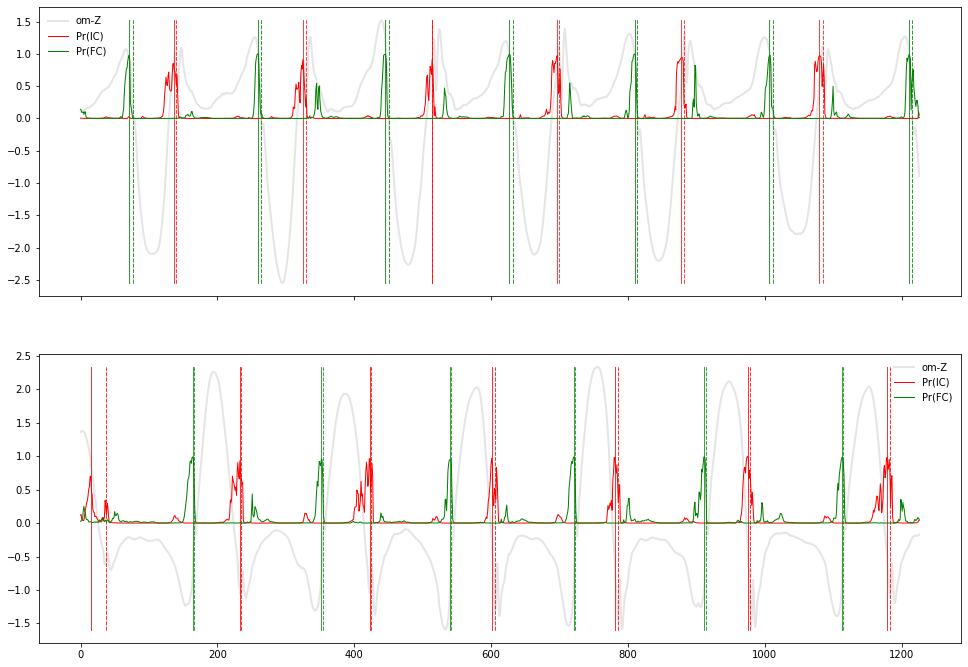

In [91]:
cm = 1/2.54

fig, axs = plt.subplots(2, 1, figsize=(42*cm, 29.7*cm), sharex=True)
axs[0].plot(data[0][:,5], c=(0, 0, 0), alpha=0.1, lw=2, label="om-Z")
for ix in np.argwhere(labels[0][:,0]==1)[:,0]:
    axs[0].plot([ix, ix], [np.min(data[0][:,5])*np.ones((len(np.argwhere(labels[0][:,0]==1)[:,0]),)), np.max(data[0][:,5])*np.ones((len(np.argwhere(labels[0][:,0]==1)[:,0]),))], ls='--', lw=1, c=(1, 0, 0), alpha=0.2)
for ix in ix_pred_ICL:
    axs[0].plot([ix, ix], [np.min(data[0][:,5])*np.ones((len(np.argwhere(labels[0][:,0]==1)[:,0]),)), np.max(data[0][:,5])*np.ones((len(np.argwhere(labels[0][:,0]==1)[:,0]),))], ls='-', lw=1, c=(1, 0, 0), alpha=0.2)
axs[0].plot(predictions[0][0][:,0], c=(1, 0, 0), lw=1, label="Pr(IC)")
for ix in np.argwhere(labels[0][:,1]==1)[:,0]:
    axs[0].plot([ix, ix], [np.min(data[0][:,5])*np.ones((len(np.argwhere(labels[0][:,1]==1)[:,0]),)), np.max(data[0][:,5])*np.ones((len(np.argwhere(labels[0][:,1]==1)[:,0]),))], ls='--', lw=1, c=(0, 0.5, 0), alpha=0.2)
for ix in ix_pred_FCL:
    axs[0].plot([ix, ix], [np.min(data[0][:,5])*np.ones((len(np.argwhere(labels[0][:,1]==1)[:,0]),)), np.max(data[0][:,5])*np.ones((len(np.argwhere(labels[0][:,1]==1)[:,0]),))], ls='-', lw=1, c=(0, 0.5, 0), alpha=0.2)
axs[0].plot(predictions[1][0][:,0], c=(0, 0.5, 0), lw=1, label="Pr(FC)")
axs[0].legend(frameon=False)

axs[1].plot(data[1][:,5], c=(0, 0, 0), alpha=0.1, lw=2, label="om-Z")
for ix in np.argwhere(labels[1][:,0]==1)[:,0]:
    axs[1].plot([ix, ix], [np.min(data[1][:,5])*np.ones((len(np.argwhere(labels[1][:,0]==1)[:,0]),)), np.max(data[1][:,5])*np.ones((len(np.argwhere(labels[1][:,0]==1)[:,0]),))], ls='--', lw=1, c=(1, 0, 0), alpha=0.2)
for ix in ix_pred_ICR:
    axs[1].plot([ix, ix], [np.min(data[1][:,5])*np.ones((len(np.argwhere(labels[1][:,0]==1)[:,0]),)), np.max(data[1][:,5])*np.ones((len(np.argwhere(labels[1][:,0]==1)[:,0]),))], ls='-', lw=1, c=(1, 0, 0), alpha=0.2)
axs[1].plot(predictions[0][1][:,0], c=(1, 0, 0), lw=1, label="Pr(IC)")
for ix in np.argwhere(labels[1][:,1]==1)[:,0]:
    axs[1].plot([ix, ix], [np.min(data[1][:,5])*np.ones((len(np.argwhere(labels[1][:,1]==1)[:,0]),)), np.max(data[1][:,5])*np.ones((len(np.argwhere(labels[1][:,1]==1)[:,0]),))], ls='--', lw=1, c=(0, 0.5, 0), alpha=0.2)
for ix in ix_pred_FCR:
    axs[1].plot([ix, ix], [np.min(data[1][:,5])*np.ones((len(np.argwhere(labels[1][:,1]==1)[:,0]),)), np.max(data[1][:,5])*np.ones((len(np.argwhere(labels[1][:,1]==1)[:,0]),))], ls='-', lw=1, c=(0, 0.5, 0), alpha=0.2)
axs[1].plot(predictions[1][1][:,0], c=(0, 0.5, 0), lw=1, label="Pr(FC)")
axs[1].legend(frameon=False)
plt.show()

## Explore the data

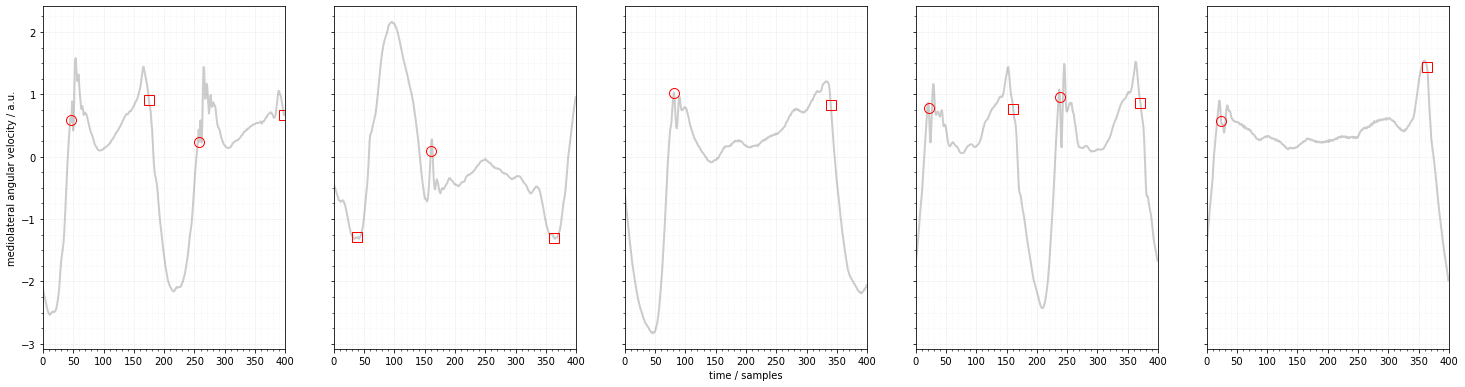

In [7]:
np.random.seed(123)
num_examples = 5
indx_random = np.random.choice(train_data.shape[0], num_examples, replace=False)
cm = 1/2.54
fig, axs = plt.subplots(1, num_examples, figsize=(64*cm, 16*cm), sharey=True)
for (i, indx) in enumerate(indx_random):
    axs[i].plot(train_data[indx][:,5], color=(0, 0, 0), alpha=0.2, lw=2)
    axs[i].plot(np.argwhere(train_labels[indx][:,0]==1)[:,0], train_data[indx][np.argwhere(train_labels[indx][:,0]==1)[:,0],5], ls="none", marker="o", mfc="none", mec=(1, 0, 0), ms=10)
    axs[i].plot(np.argwhere(train_labels[indx][:,1]==1)[:,0], train_data[indx][np.argwhere(train_labels[indx][:,1]==1)[:,0],5], ls="none", marker="s", mfc="none", mec=(1, 0, 0), ms=10)
    axs[i].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[i].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[i].grid(True, which="minor", ls=":", color=(0, 0, 0), alpha=0.05)
    axs[i].grid(True, which="major", color=(0, 0, 0), alpha=0.05)
    axs[i].set_xlim((0, train_data[indx].shape[0]))
axs[0].set_ylabel("mediolateral angular velocity / a.u.")
axs[num_examples//2].set_xlabel("time / samples")
plt.show()

## Build model

In [8]:
tcn_model = get_base_model(input_shape=train_data.shape[1:], num_classes=train_labels.shape[-1])
tcn_model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 6)]    0           []                               
                                                                                                  
 tcn_layer (TCN)                (None, None, 64)     137536      ['inputs[0][0]']                 
                                                                                                  
 outputs_1 (Dense)              (None, None, 1)      65          ['tcn_layer[0][0]']              
                                                                                                  
 outputs_2 (Dense)              (None, None, 1)      65          ['tcn_layer[0][0]']              
                                                                                          

In [9]:
train_targets, val_targets = {}, {}
for i in range(train_labels.shape[-1]):
    train_targets[f"outputs_{i+1}"] = np.expand_dims(train_labels[:,:,i], axis=-1)
    val_targets[f"outputs_{i+1}"] = np.expand_dims(val_labels[:,:,i], axis=-1)

In [10]:
history = tcn_model.fit(x=train_data, y=train_targets, batch_size=32, epochs=5, validation_data=(val_data, val_targets), shuffle=True)

Epoch 1/5
109/109 [==============================] - 19s 113ms/step - loss: 0.0122 - outputs_1_loss: 0.0069 - outputs_2_loss: 0.0053 - outputs_1_binary_accuracy: 0.9132 - outputs_2_binary_accuracy: 0.9138 - val_loss: 0.0083 - val_outputs_1_loss: 0.0043 - val_outputs_2_loss: 0.0040 - val_outputs_1_binary_accuracy: 0.9421 - val_outputs_2_binary_accuracy: 0.9439
Epoch 2/5
109/109 [==============================] - 10s 90ms/step - loss: 0.0053 - outputs_1_loss: 0.0027 - outputs_2_loss: 0.0026 - outputs_1_binary_accuracy: 0.9493 - outputs_2_binary_accuracy: 0.9470 - val_loss: 0.0081 - val_outputs_1_loss: 0.0040 - val_outputs_2_loss: 0.0041 - val_outputs_1_binary_accuracy: 0.9465 - val_outputs_2_binary_accuracy: 0.9563
Epoch 3/5
109/109 [==============================] - 10s 93ms/step - loss: 0.0043 - outputs_1_loss: 0.0022 - outputs_2_loss: 0.0021 - outputs_1_binary_accuracy: 0.9554 - outputs_2_binary_accuracy: 0.9542 - val_loss: 0.0081 - val_outputs_1_loss: 0.0040 - val_outputs_2_loss: 0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


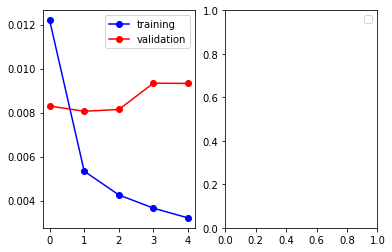

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(history.history["loss"], 'bo-', label="training")
axs[0].plot(history.history["val_loss"], 'ro-', label="validation")
axs[0].legend()
# axs[1].plot(h.history["binary_accuracy"], 'bo-', label="training")
# axs[1].plot(h.history["val_binary_accuracy"], 'ro-', label="validation")
axs[1].legend()
plt.show()

In [12]:
predictions = tcn_model.predict(val_data)

In [13]:
for i in range(len(predictions)):
    print(f"{predictions[i].shape}")

(714, 400, 1)
(714, 400, 1)


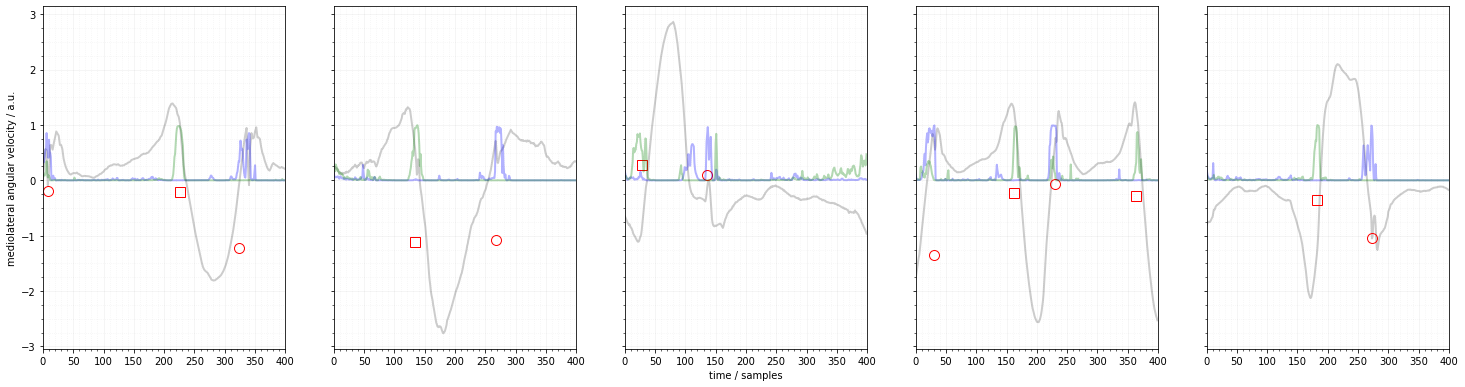

In [14]:
num_examples = 5
indx_random = np.random.choice(val_data.shape[0], num_examples, replace=False)
cm = 1/2.54
fig, axs = plt.subplots(1, num_examples, figsize=(64*cm, 16*cm), sharey=True)
for (i, indx) in enumerate(indx_random):
    axs[i].plot(val_data[indx][:,5], color=(0, 0, 0), alpha=0.2, lw=2)
    axs[i].plot(np.argwhere(val_labels[indx][:,0]==1)[:,0], train_data[indx][np.argwhere(val_labels[indx][:,0]==1)[:,0],5], ls="none", marker="o", mfc="none", mec=(1, 0, 0), ms=10)
    axs[i].plot(np.argwhere(val_labels[indx][:,1]==1)[:,0], train_data[indx][np.argwhere(val_labels[indx][:,1]==1)[:,0],5], ls="none", marker="s", mfc="none", mec=(1, 0, 0), ms=10)
    axs[i].plot(predictions[0][indx][:,0], color=(0, 0, 1), alpha=0.3, lw=2)
    axs[i].plot(predictions[1][indx][:,0], color=(0, 0.5, 0), alpha=0.3, ls="-", lw=2)
    axs[i].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[i].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[i].grid(True, which="minor", ls=":", color=(0, 0, 0), alpha=0.05)
    axs[i].grid(True, which="major", color=(0, 0, 0), alpha=0.05)
    axs[i].set_xlim((0, val_data[indx].shape[0]))
axs[0].set_ylabel("mediolateral angular velocity / a.u.")
axs[num_examples//2].set_xlabel("time / samples")
plt.show()

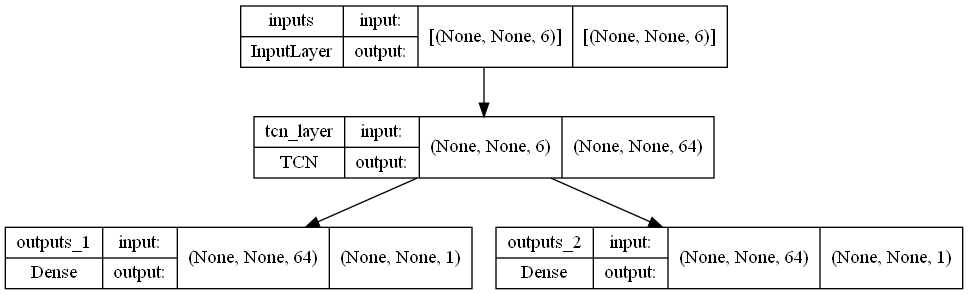

In [15]:
keras.utils.plot_model(tcn_model, show_shapes=True, show_layer_names=True)

## Test: Hyperparameter Tuning

### Run: 3 
Designing a custom class that inherits from the HyperModel class, and can be passed additional arguments.

In [16]:
class TCNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes, weights=None):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.weights = weights
    
    def build(self, hp):
        # Define the layers
        inputs = keras.layers.Input(shape=(None, self.input_shape[-1]), name="inputs")
        tcn = TCN(
            nb_filters=2**hp.Int("nb_filters", min_value=3, max_value=7, step=1),
            kernel_size=hp.Int("kernel_size", min_value=3, max_value=7, step=2),
            padding=hp.Choice("padding", ["causal", "same"], ordered=False, default="same"),
            dilations=[2**i for i in range(hp.Int("dilations", min_value=2, max_value=6, step=1))],
            return_sequences=True,
            name="tcn_layer"
        )(inputs)
        outputs = []
        for i in range(self.num_classes):
            outputs.append(keras.layers.Dense(units=1, activation="sigmoid", name=f"outputs_{i+1}")(tcn))
        
        # Instantiate the model
        model = keras.models.Model(inputs=inputs, outputs=outputs, name="tcn_model")

        # Define losses and metrics for each output
        losses, metrics = {}, {}
        for i in range(self.num_classes):
            if (self.weights is None) or (len(self.weights)==0):
                losses[f"outputs_{i+1}"] = MyWeightedBinaryCrossentropy(weights=0.01)
            else:
                losses[f"outputs_{i+1}"] = MyWeightedBinaryCrossentropy(weights=self.weights[f"outputs_{i+1}"])
            metrics[f"outputs_{i+1}"] = keras.metrics.BinaryAccuracy()
        
        # Compile the model
        model.compile(
            loss=losses,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=metrics
        )
        return model

In [17]:
tuner = kt.RandomSearch(
    hypermodel=TCNHyperModel(input_shape=train_data.shape[1:], num_classes=train_labels.shape[-1]),
    objective="val_loss", 
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="D:\\Desktop",
    project_name="Pegasus"
)

In [18]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
nb_filters (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 1, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': None}
padding (Choice)
{'default': 'same', 'conditions': [], 'values': ['causal', 'same'], 'ordered': False}
dilations (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}


In [19]:
tuner.search(train_data, train_targets, epochs=2, validation_data=(val_data, val_targets))

Trial 3 Complete [00h 00m 49s]
val_loss: 0.007982830982655287

Best val_loss So Far: 0.00746816280297935
Total elapsed time: 00h 02m 15s
INFO:tensorflow:Oracle triggered exit


In [20]:
best_hps = tuner.get_best_hyperparameters()[0]
optim_model = tuner.hypermodel.build(best_hps)
optim_model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 6)]    0           []                               
                                                                                                  
 tcn_layer (TCN)                (None, None, 128)    415104      ['inputs[0][0]']                 
                                                                                                  
 outputs_1 (Dense)              (None, None, 1)      129         ['tcn_layer[0][0]']              
                                                                                                  
 outputs_2 (Dense)              (None, None, 1)      129         ['tcn_layer[0][0]']              
                                                                                          

### Run: 2
Designing a wrapper function that takes additional arguments, and outputs the hypermodel building function.

In [51]:
def build_model_fn(input_shape, num_classes, weights=None, **kwargs):
    # Define the layers
    inputs = keras.layers.Input(shape=(None, input_shape[-1]), name="inputs")
    tcn = TCN(
        return_sequences=True,
        name="tcn_layer", 
        **kwargs
    )(inputs)
    outputs = []
    for i in range(num_classes):
        outputs.append(keras.layers.Dense(units=1, activation="sigmoid", name=f"outputs_{i+1}")(tcn))
    
    # Instantiate the model
    model = keras.models.Model(inputs=inputs, outputs=outputs, name="tcn_model")

    # Define losses and metrics for each output
    losses, metrics = {}, {}
    for i in range(num_classes):
        if (weights is None) or (len(weights)==0):
            losses[f"outputs_{i+1}"] = MyWeightedBinaryCrossentropy(weights=0.01)
        else:
            losses[f"outputs_{i+1}"] = MyWeightedBinaryCrossentropy(weights=weights)
        metrics[f"outputs_{i+1}"] = keras.metrics.BinaryAccuracy()
    
    # Compile the model
    model.compile(
        loss=losses,
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=metrics
    )
    return model


In [52]:
def wrapper_build_hypermodel_fn(input_shape, num_classes, weights=None):
    def build_hypermodel_fn(hp):
        # Define hyperparameters to tune
        nb_filters = 2**hp.Int("nb_filters_exp", min_value=3, max_value=7, step=1)
        kernel_size = hp.Int("kernel_size", min_value=3, max_value=7, step=2)
        dilations = [2**i for i in range(hp.Int("dilations", min_value=2, max_value=5, step=1))]
        padding = hp.Choice("padding", ["causal", "same"], ordered=False, default="same")

        # Call build model function
        model = build_model_fn(
            input_shape=input_shape, 
            num_classes=num_classes,
            weights=weights, 
            **{"nb_filters": nb_filters, "kernel_size": kernel_size, "dilations": dilations, "padding": padding}
        )
        return model
    return build_hypermodel_fn

In [54]:
# Instantiate a KerasTuner object
tuner = kt.RandomSearch(
    hypermodel=wrapper_build_hypermodel_fn(train_data.shape[1:], train_labels.shape[-1], weights=0.01),
    objective="val_loss", 
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="D:\\Desktop",
    project_name="Pegasus"
)

TypeError: object of type 'float' has no len()

### Run 1: 
Calling existing code to build the base model architecture.

In [37]:
def call_existing_code(nb_filters, kernel_size, padding, dilations):
    input_layer = keras.layers.Input(shape=(None, 6), name="input_layer")
    tcn_layer = TCN(
        nb_filters=nb_filters,
        kernel_size=kernel_size,
        padding=padding,
        dilations=dilations,
        return_sequences=True,
        name="tcn_layer"
    )(input_layer)
    output_layer = []
    for i in range(2):
        output_layer.append(keras.layers.Dense(units=1, activation="sigmoid", name=f"output_layer_{i+1}")(tcn_layer))
    
    tcn_model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="tcn_model")

    losses, metrics = {}, {}
    for i in range(2):
        losses[f"output_layer_{i+1}"] = MyWeightedBinaryCrossentropy(weights=0.005)
        metrics[f"output_layer_{i+1}"] = keras.metrics.BinaryAccuracy()
    
    tcn_model.compile(
        loss=losses,
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=metrics
    )
    return tcn_model

def build_hypermodel(hp):
    # Hyperparameters to tune
    nb_filters = 2**hp.Int("nb_filters", min_value=3, max_value=7, step=1)
    kernel_size = hp.Int("kernel_size", min_value=3, max_value=7, step=2)
    padding = hp.Choice("padding", ["same", "causal"], ordered=False, default="same")
    max_dilation = hp.Int("max_dilation", min_value=2, max_value=5)
    dilations = [2**i for i in range(max_dilation)]

    # Call existing model-building code with the hyperparameter values
    model = call_existing_code(
        nb_filters=nb_filters,
        kernel_size=kernel_size,
        padding=padding,
        dilations=dilations
    )
    return model

In [38]:
# Instantiate a KerasTuner object
tuner = kt.RandomSearch(
    hypermodel=build_hypermodel,
    objective="val_loss", 
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="D:\\Desktop",
    project_name="Pegasus"
)

In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
nb_filters (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 1, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': None}
padding (Choice)
{'default': 'same', 'conditions': [], 'values': ['same', 'causal'], 'ordered': False}
max_dilation (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}


In [40]:
tuner.search(train_data, train_targets, epochs=2, validation_data=(val_data, val_targets))

Trial 3 Complete [00h 00m 14s]
val_loss: 0.0058442289009690285

Best val_loss So Far: 0.005489871138706803
Total elapsed time: 00h 01m 05s
INFO:tensorflow:Oracle triggered exit


In [41]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]

In [43]:
best_model.build(input_shape=(None, 6))
best_model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, None, 6)]    0           []                               
                                                                                                  
 tcn_layer (TCN)                (None, None, 32)     66400       ['input_layer[0][0]']            
                                                                                                  
 output_layer_1 (Dense)         (None, None, 1)      33          ['tcn_layer[0][0]']              
                                                                                                  
 output_layer_2 (Dense)         (None, None, 1)      33          ['tcn_layer[0][0]']              
                                                                                          

In [44]:
tuner.results_summary()

Results summary
Results in D:\Desktop\Pegasus
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
nb_filters: 5
kernel_size: 7
padding: causal
max_dilation: 5
Score: 0.005489871138706803
Trial summary
Hyperparameters:
nb_filters: 4
kernel_size: 7
padding: causal
max_dilation: 4
Score: 0.0056605401914566755
Trial summary
Hyperparameters:
nb_filters: 4
kernel_size: 5
padding: causal
max_dilation: 2
Score: 0.0058442289009690285


In [45]:
best_hps = tuner.get_best_hyperparameters()[0]
optim_model = tuner.hypermodel.build(best_hps)
optim_model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, None, 6)]    0           []                               
                                                                                                  
 tcn_layer (TCN)                (None, None, 32)     66400       ['input_layer[0][0]']            
                                                                                                  
 output_layer_1 (Dense)         (None, None, 1)      33          ['tcn_layer[0][0]']              
                                                                                                  
 output_layer_2 (Dense)         (None, None, 1)      33          ['tcn_layer[0][0]']              
                                                                                          